# SABR Implied Volatility Surface (3D)

This notebook visualises the **SABR implied volatility surface**:

- Uses the lognormal SABR model with parameters \\((\alpha, \beta, \rho, \nu)\\)
- Computes the Black–Scholes-equivalent implied volatility \\(\sigma_\text{BS}(K, T)\\)
- Plots a 3D surface in strike–maturity space: \\(\sigma(K, T)\\)
- Shows 2D smiles (vol vs strike) for different maturities
- Optionally adds **noise** to mimic messy real-world market data, and overlays
  a smooth SABR model on top of noisy “market” vols.


In [32]:
import warnings
warnings.filterwarnings("ignore") 
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from mpl_toolkits.mplot3d import Axes3D 

In [34]:
@dataclass
class SabrParams:
    """
    Parameters of the lognormal SABR model.

    alpha : initial volatility level (>0)
    beta  : elasticity in [0, 1]
    rho   : correlation in [-1, 1]
    nu    : volatility of volatility (>0)
    """
    alpha: float
    beta: float
    rho: float
    nu: float


def sabr_implied_vol_hagan(F0, K, T, params: SabrParams, eps=1e-7):
    """
    Hagan et al. lognormal SABR implied volatility approximation.

    Parameters
    ----------
    F0 : float
        Forward price at time 0 (here we just treat it like S0).
    K : float or array-like
        Strike(s) > 0.
    T : float
        Maturity in years.
    params : SabrParams
        SABR parameters (alpha, beta, rho, nu).
    eps : float
        Threshold for deciding F0 ~ K (ATM limit).

    Returns
    -------
    float or np.ndarray
        Black–Scholes-equivalent implied vol(s).
    """
    alpha = float(params.alpha)
    beta = float(params.beta)
    rho = float(params.rho)
    nu = float(params.nu)

    if F0 <= 0.0:
        raise ValueError("F0 must be positive for lognormal SABR.")
    if T < 0.0:
        raise ValueError("T must be non-negative.")
    if alpha <= 0.0:
        raise ValueError("alpha must be positive.")
    if nu <= 0.0:
        raise ValueError("nu must be positive.")
    if not (0.0 <= beta <= 1.0):
        raise ValueError("beta must be in [0, 1].")
    if not (-1.0 <= rho <= 1.0):
        raise ValueError("rho must be in [-1, 1].")

    K_arr = np.asarray(K, dtype=float)
    if np.any(K_arr <= 0.0):
        raise ValueError("All strikes must be positive for lognormal SABR.")

    one_minus_beta = 1.0 - beta
    log_FK = np.log(F0 / K_arr)

    is_atm = np.abs(log_FK) < eps
    is_not_atm = ~is_atm

    sigma = np.zeros_like(K_arr, dtype=float)

    # --- ATM case ---
    if np.any(is_atm):
        F_beta = F0 ** one_minus_beta
        sigma_atm = alpha / F_beta

        term1 = ((one_minus_beta ** 2) / 24.0) * (alpha ** 2) / (F_beta ** 2)
        term2 = 0.25 * rho * beta * nu * alpha / F_beta
        term3 = ((2.0 - 3.0 * rho * rho) / 24.0) * (nu ** 2)

        correction = 1.0 + T * (term1 + term2 + term3)
        sigma[is_atm] = sigma_atm * correction

    # --- Non-ATM case ---
    if np.any(is_not_atm):
        K_ = K_arr[is_not_atm]
        log_FK_ = log_FK[is_not_atm]

        FK_beta = (F0 * K_) ** (0.5 * one_minus_beta)
        z = (nu / alpha) * FK_beta * log_FK_

        sqrt_term = np.sqrt(1.0 - 2.0 * rho * z + z * z)
        numerator = sqrt_term + z - rho
        denominator = 1.0 - rho
        x_z = np.log(numerator / denominator)

        # A(F0, K)
        A = alpha / (
            FK_beta
            * (
                1.0
                + (one_minus_beta**2 / 24.0) * (log_FK_**2)
                + (one_minus_beta**4 / 1920.0) * (log_FK_**4)
            )
        )

        zx = z / x_z

        term1 = ((one_minus_beta ** 2) / 24.0) * (alpha ** 2) / (FK_beta ** 2)
        term2 = 0.25 * rho * beta * nu * alpha / FK_beta
        term3 = ((2.0 - 3.0 * rho * rho) / 24.0) * (nu ** 2)
        B = 1.0 + T * (term1 + term2 + term3)

        sigma_non_atm = A * zx * B
        sigma[is_not_atm] = sigma_non_atm

    # --- Return scalar or array cleanly ---
    if sigma.ndim == 0:  # 0-D array for scalar K
        return float(sigma)
    else:
        return sigma


In [36]:
def compute_sabr_surface(
    F0: float,
    params: SabrParams,
    T_min: float = 0.1,
    T_max: float = 2.0,
    n_T: int = 25,
    strike_span: float = 0.4,
    n_K: int = 41,
    noise_level: float = 0.0,
    seed: int | None = 42,
):
    """
    Compute a SABR implied volatility surface sigma(K, T) on a grid.

    If noise_level > 0, we multiply the smooth SABR vols by
    (1 + eps) with eps ~ N(0, noise_level). This mimics noisy
    real-world implied vols.

    Parameters
    ----------
    F0 : float
        Forward / spot level.
    params : SabrParams
        SABR parameters.
    T_min, T_max : float
        Minimum and maximum maturity in years.
    n_T : int
        Number of maturity points.
    strike_span : float
        Strikes in [F0 * (1 - span), F0 * (1 + span)].
    n_K : int
        Number of strike points.
    noise_level : float
        Relative noise std. Example: 0.1 -> 10% vol noise.
    seed : int or None
        RNG seed for reproducibility when noise_level > 0.

    Returns
    -------
    T_grid, K_grid, sigma_grid : np.ndarray
        Grids of shape (n_T, n_K) for T, K, and implied volatility.
    """
    T_vals = np.linspace(T_min, T_max, n_T)
    K_min = F0 * (1.0 - strike_span)
    K_max = F0 * (1.0 + strike_span)
    K_vals = np.linspace(K_min, K_max, n_K)

    T_grid, K_grid = np.meshgrid(T_vals, K_vals, indexing="ij")
    sigma_grid = np.zeros_like(T_grid, dtype=float)

    rng = np.random.default_rng(seed) if noise_level > 0.0 else None

    for i, T in enumerate(T_vals):
        base_vols = sabr_implied_vol_hagan(F0, K_vals, T, params)

        if noise_level > 0.0:
            eps = rng.normal(0.0, noise_level, size=base_vols.shape)
            noisy_vols = base_vols * (1.0 + eps)
            sigma_grid[i, :] = np.maximum(noisy_vols, 1e-4)
        else:
            sigma_grid[i, :] = base_vols

    return T_grid, K_grid, sigma_grid


In [38]:
def plot_sabr_surface_3d(
    F0: float,
    params: SabrParams,
    T_min: float = 0.1,
    T_max: float = 2.0,
    n_T: int = 25,
    strike_span: float = 0.4,
    n_K: int = 41,
    noise_level: float = 0.0,
    seed: int = 42,
):
    """
    Plot a 3D SABR implied volatility surface sigma(K, T).

    If noise_level > 0, we show:
    - a smooth SABR wireframe (model)
    - a noisy surface (pseudo "market" vols)
    """
    # Noisy "market" vols
    T_grid, K_grid, sigma_noisy = compute_sabr_surface(
        F0=F0,
        params=params,
        T_min=T_min,
        T_max=T_max,
        n_T=n_T,
        strike_span=strike_span,
        n_K=n_K,
        noise_level=noise_level,
        seed=seed,
    )

    # Smooth "model" vols
    _, _, sigma_smooth = compute_sabr_surface(
        F0=F0,
        params=params,
        T_min=T_min,
        T_max=T_max,
        n_T=n_T,
        strike_span=strike_span,
        n_K=n_K,
        noise_level=0.0,
    )

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Noisy surface (market-like)
    surf = ax.plot_surface(
        K_grid,
        T_grid,
        sigma_noisy,
        linewidth=0,
        antialiased=True,
        alpha=0.8,
    )

    # Smooth model as wireframe on top
    ax.plot_wireframe(
        K_grid,
        T_grid,
        sigma_smooth,
        color="black",
        linewidth=0.4,
        alpha=0.7,
    )

    ax.set_xlabel("Strike K")
    ax.set_ylabel("Maturity T (years)")
    ax.set_zlabel("Implied volatility")
    title = "SABR Implied Volatility Surface"
    if noise_level > 0:
        title += " (smooth model + noisy market)"
    ax.set_title(title)

    fig.colorbar(surf, shrink=0.6, aspect=15, label="Noisy implied vol")
    plt.show()


def plot_sabr_smile_slices(
    F0: float,
    params: SabrParams,
    maturities,
    strike_span: float = 0.4,
    n_K: int = 101,
    noise_level: float = 0.0,
    seed: int = 123,
):
    """
    Plot 2D SABR smiles (vol vs strike) for multiple maturities.

    If noise_level > 0, we overlay:
    - smooth SABR smile (line)
    - noisy "market" vols (scatter points)
    """
    K_min = F0 * (1.0 - strike_span)
    K_max = F0 * (1.0 + strike_span)
    K_vals = np.linspace(K_min, K_max, n_K)

    rng = np.random.default_rng(seed) if noise_level > 0.0 else None

    plt.figure(figsize=(10, 5))
    for T in maturities:
        vols_smooth = sabr_implied_vol_hagan(F0, K_vals, T, params)
        plt.plot(K_vals, vols_smooth, linewidth=1.5, label=f"T = {T:.2f}y (model)")

        if noise_level > 0.0:
            eps = rng.normal(0.0, noise_level, size=vols_smooth.shape)
            vols_noisy = np.maximum(vols_smooth * (1.0 + eps), 1e-4)
            plt.scatter(
                K_vals,
                vols_noisy,
                s=12,
                alpha=0.6,
                label=f"T = {T:.2f}y (market)",
            )

    plt.title("SABR Implied Volatility Smiles at Different Maturities\n(model vs noisy market)")
    plt.xlabel("Strike K")
    plt.ylabel("Implied volatility")
    plt.grid(True)
    plt.legend()
    plt.show()


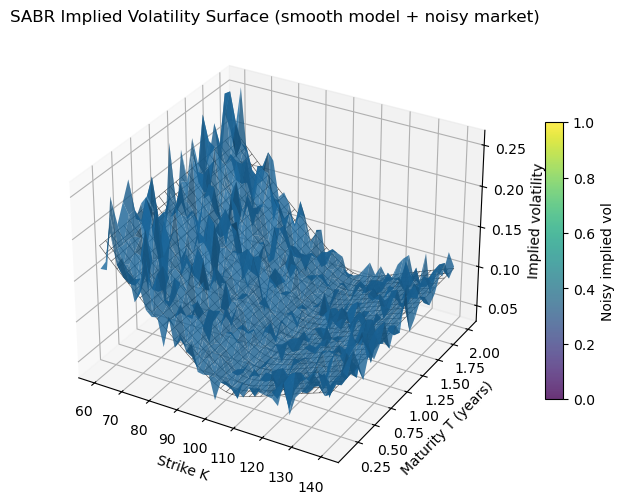

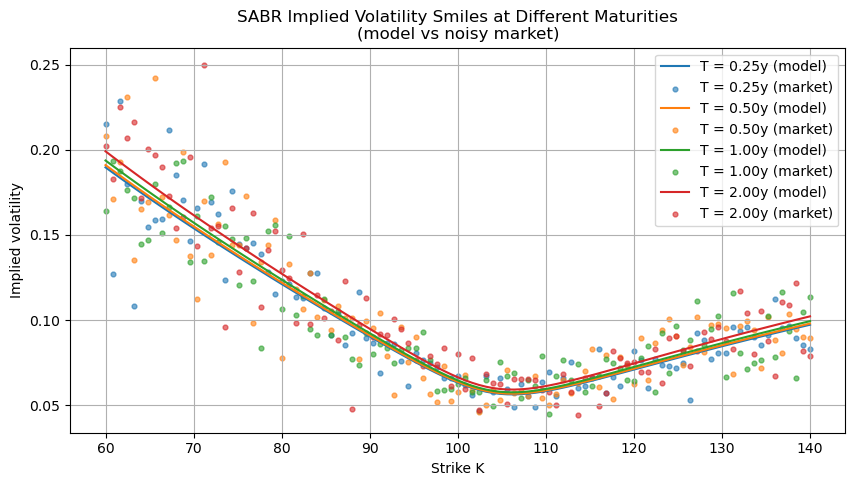

In [40]:
# Example SABR parameters (tweak these to explore different shapes)
F0 = 100.0
params_example = SabrParams(
    alpha=0.25,  # overall level
    beta=0.7,    # elasticity (0=normal, 1=lognormal)
    rho=-0.5,    # negative correlation -> downside skew
    nu=0.8,      # vol-of-vol -> smile curvature
)

# 15% relative noise in implied vols -> bumpy, more "real world"
noise_level = 0.15

plot_sabr_surface_3d(
    F0=F0,
    params=params_example,
    T_min=0.1,
    T_max=2.0,
    n_T=25,
    strike_span=0.4,
    n_K=41,
    noise_level=noise_level,
    seed=123,
)

plot_sabr_smile_slices(
    F0=F0,
    params=params_example,
    maturities=[0.25, 0.5, 1.0, 2.0],
    strike_span=0.4,
    n_K=101,
    noise_level=noise_level,
    seed=456,
)
